In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
%cd /content/drive/MyDrive/MyFlowerDataset

/content/drive/MyDrive/MyFlowerDataset


In [41]:
import shutil
import os

# Define the path to the folder in Google Drive
folder_path = '/content/drive/MyDrive/MyFlowerDataset'
target_path = '/content/MyFlowerDataset'

# Check if the target directory exists and remove it if it does
if os.path.exists(target_path):
    shutil.rmtree(target_path)

# Copy the folder to Google Colab
shutil.copytree(folder_path, target_path)

'/content/MyFlowerDataset'

In [42]:
import random

data_folder = '/content/MyFlowerDataset'

files = os.listdir(data_folder)

for file_name in files:

    os.makedirs(f'/content/train/{file_name}', exist_ok=True)
    os.makedirs(f'/content/test/{file_name}', exist_ok=True)

    images = os.listdir(os.path.join(data_folder, file_name))

    num_train_images = int(0.8 * len(images))

    random.shuffle(images)

    train_images = images[:num_train_images]
    test_images = images[num_train_images:]

    for img in train_images:
        shutil.move(os.path.join(data_folder, file_name, img), f'/content/train/{file_name}/{img}')

    for img in test_images:
        shutil.move(os.path.join(data_folder, file_name, img), f'/content/test/{file_name}/{img}')

print(f"Total files: {len(files)}")

Total files: 5


In [43]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten

In [44]:
#generate
train_ds=keras.utils.image_dataset_from_directory(
    directory='/content/train',
    labels='inferred',
    label_mode='int',
    batch_size=8,
    image_size=(256,256)
)

validation_ds=keras.utils.image_dataset_from_directory(
    directory='/content/test',
    labels='inferred',
    label_mode='int',
    batch_size=8,
    image_size=(256,256)
)

Found 396 files belonging to 5 classes.
Found 150 files belonging to 5 classes.


In [45]:
#create CNN model
model = Sequential()

model.add(Conv2D(32,kernel_size=(3,3),padding='valid',activation='relu',input_shape=(256,256,3)))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(64,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(128,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Flatten())

model.add(Dense(256,activation='relu'))
model.add(Dense(128,activation='relu'))

model.add(Dense(5,activation='softmax'))#5 flowers

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 127, 127, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 62, 62, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_20 (Conv2D)          (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 30, 30, 128)      

In [46]:
#Normalize
def process(image,label):
  image=tf.cast(image/255. ,tf.float32)
  return image, label

train_ds = train_ds.map(process)
validation_ds= validation_ds.map(process)

In [47]:
learning_rate = .00001
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate),loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [48]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_ds,
    epochs=20,
    validation_data=validation_ds,
    callbacks=[early_stopping]
)

Epoch 1/20
50/50 [==============================] - 4s 68ms/step - loss: 1.4775 - accuracy: 0.4949 - val_loss: 1.2654 - val_accuracy: 0.7067
Epoch 2/20
50/50 [==============================] - 2s 33ms/step - loss: 1.1289 - accuracy: 0.7045 - val_loss: 0.9236 - val_accuracy: 0.8000
Epoch 3/20
50/50 [==============================] - 2s 33ms/step - loss: 0.8492 - accuracy: 0.7904 - val_loss: 0.6858 - val_accuracy: 0.8867
Epoch 4/20
50/50 [==============================] - 2s 33ms/step - loss: 0.6521 - accuracy: 0.8308 - val_loss: 0.5443 - val_accuracy: 0.8733
Epoch 5/20
50/50 [==============================] - 2s 33ms/step - loss: 0.5296 - accuracy: 0.8586 - val_loss: 0.4513 - val_accuracy: 0.8800
Epoch 6/20
50/50 [==============================] - 3s 48ms/step - loss: 0.4389 - accuracy: 0.8939 - val_loss: 0.3662 - val_accuracy: 0.9200
Epoch 7/20
50/50 [==============================] - 2s 34ms/step - loss: 0.3589 - accuracy: 0.9192 - val_loss: 0.3237 - val_accuracy: 0.9267
Epoch 8/20
50

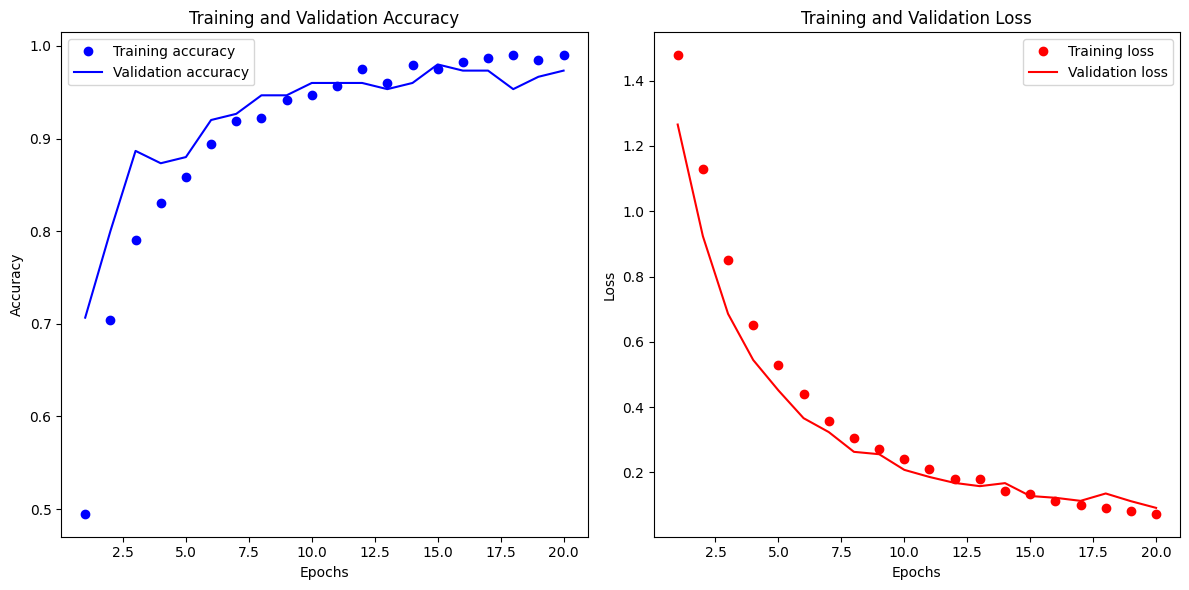

In [49]:
import matplotlib.pyplot as plt

# Retrieve history data
history_dict = history.history

# Extract accuracy and loss values
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Get the number of epochs
epochs = range(1, len(accuracy) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

In [51]:
# Save the model in Keras format to Google Drive
model.save('/content/drive/My Drive/FlowerRecognitionAndClassificationModel/MyFlowerRecognitionModelKerasFormat.keras')

# Save the model in HDF5 format
model.save('/content/drive/My Drive/FlowerRecognitionAndClassificationModel/MyFlowerRecognitionModelh5Format.h5')